In [1]:
"""
This notebook is used for model hyper-parameter searching.
"""
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from typing import Dict, List

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import sys
sys.path.append("../")
# If this notebook file is not placed under in /notebook/ directory,
# adding directory "../" might not correly add the project directory.
# If adding "../" does not solve the importing problem, we need to setup 
# the directory mannually.
try:
    import constants
except ModuleNotFoundError:
    core_dir = input("Directory of core files >>> ")
    if not core_dir.endswith("/"):
        core_dir += "/"
    sys.path.append(core_dir)
    import constants

In [3]:
from core.tools.metrics import *
import core.tools.visualize as visualize
from core.tools.time_series import *
from core.tools.data_import import *
import core.tools.rnn_prepare as rnn_prepare

import core.models.stacked_lstm as stacked_lstm

import core.training.hps_methods as hps_methods

In [4]:
# data preparation phase.
pprint(constants.DATA_DIR)
choice = None
while choice is None or choice not in constants.DATA_DIR.keys():
    if choice is not None:
        print("Invalid data location received, try again...")
    choice = input("Select Dataset >>> ")
FILE_DIR = constants.DATA_DIR[choice]

print(f"Dataset chosen: {FILE_DIR}")

print("Avaiable configuration files found: ")
for cf in os.listdir("../hps_configs"):
    if cf.endswith("config.py"):
        print("\t" + cf)

config_name = input("Select config file >>> ")
if config_name.endswith(".py"):
    config_name = config_name[:-3]

exec(f"import hps_configs.{config_name} as config")

print("Reading configuration file...")
for att in dir(config):
    if att.endswith("_config"):
        print(f"\tLoading: {att}")
        exec(f"globals().update(config.{att})")

{'a': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv',
 'b': '/home/ec2-user/AnnEconForecast/data/UNRATE.csv',
 'c': '/home/ec2-user/AnnEconForecast/data/DEXCAUS.csv'}
Select Dataset >>> a
Dataset chosen: /Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv
Avaiable configuration files found: 
	sample_config.py
	ec2_config.py
	mac_config.py
Select config file >>> mac_config
Reading configuration file...
	Loading: dp_config


In [5]:
parameter_collection = hps_methods.gen_hparam_set(
    config.train_param
)

Total number of parameter sets generated: 4


In [6]:
PERIODS

1

In [7]:
pprint(parameter_collection[0])

{'clip_grad': None,
 'epochs': 50,
 'fig_path': '/Volumes/Intel/annef_model_data/2018DEC17_MAC_01/model_figs/num_neurons=(16, '
             '32)-learning_rate=0.1',
 'hparam_str': 'num_neurons=(16, 32)-learning_rate=0.1',
 'learning_rate': 0.1,
 'model_path': '/Volumes/Intel/annef_model_data/2018DEC17_MAC_01/saved_models/num_neurons=(16, '
               '32)-learning_rate=0.1',
 'num_inputs': 1,
 'num_neurons': (16, 32),
 'num_outputs': 1,
 'num_time_steps': 4,
 'report_periods': 10,
 'tensorboard_dir': '/Volumes/Intel/annef_model_data/2018DEC17_MAC_01/tensorboard/num_neurons=(16, '
                    '32)-learning_rate=0.1'}


In [8]:
# Check here.

Executing hyper-parameter searching session [0/3]...
Session Config:
	num_neurons=(16, 32)
	learning_rate=0.1
Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64
StandardScaler applied, scaling based on the first 679 observations.
Total 844 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (844, 4, 1), y shape = (844, 1, 1)
Training and testing set generated,        
X_train shape: (674, 4, 1)        
y_train shape: (674, 1)        
X_test shape: (85, 4, 1)        
y_test shape: (85, 1)        
X_validation shape: (85, 4, 1)        
y_validation shape: (85, 1)

Iteration [0], Training MSE 40.2782364; Validation MSE 50.4609718
Saving the trained model...
Time taken for [50] epochs:  0:00:01.528863
Loss Summary:
	mae=0.523198127746582
	mse=0.4304729998111725
	rmse=0.6561043858528137
	mape=4.876245498657227
Time taken for session [0]: 0:00:03.357821.
Executing hyper-parameter searching session [1/3]...
Session Config:
	num_

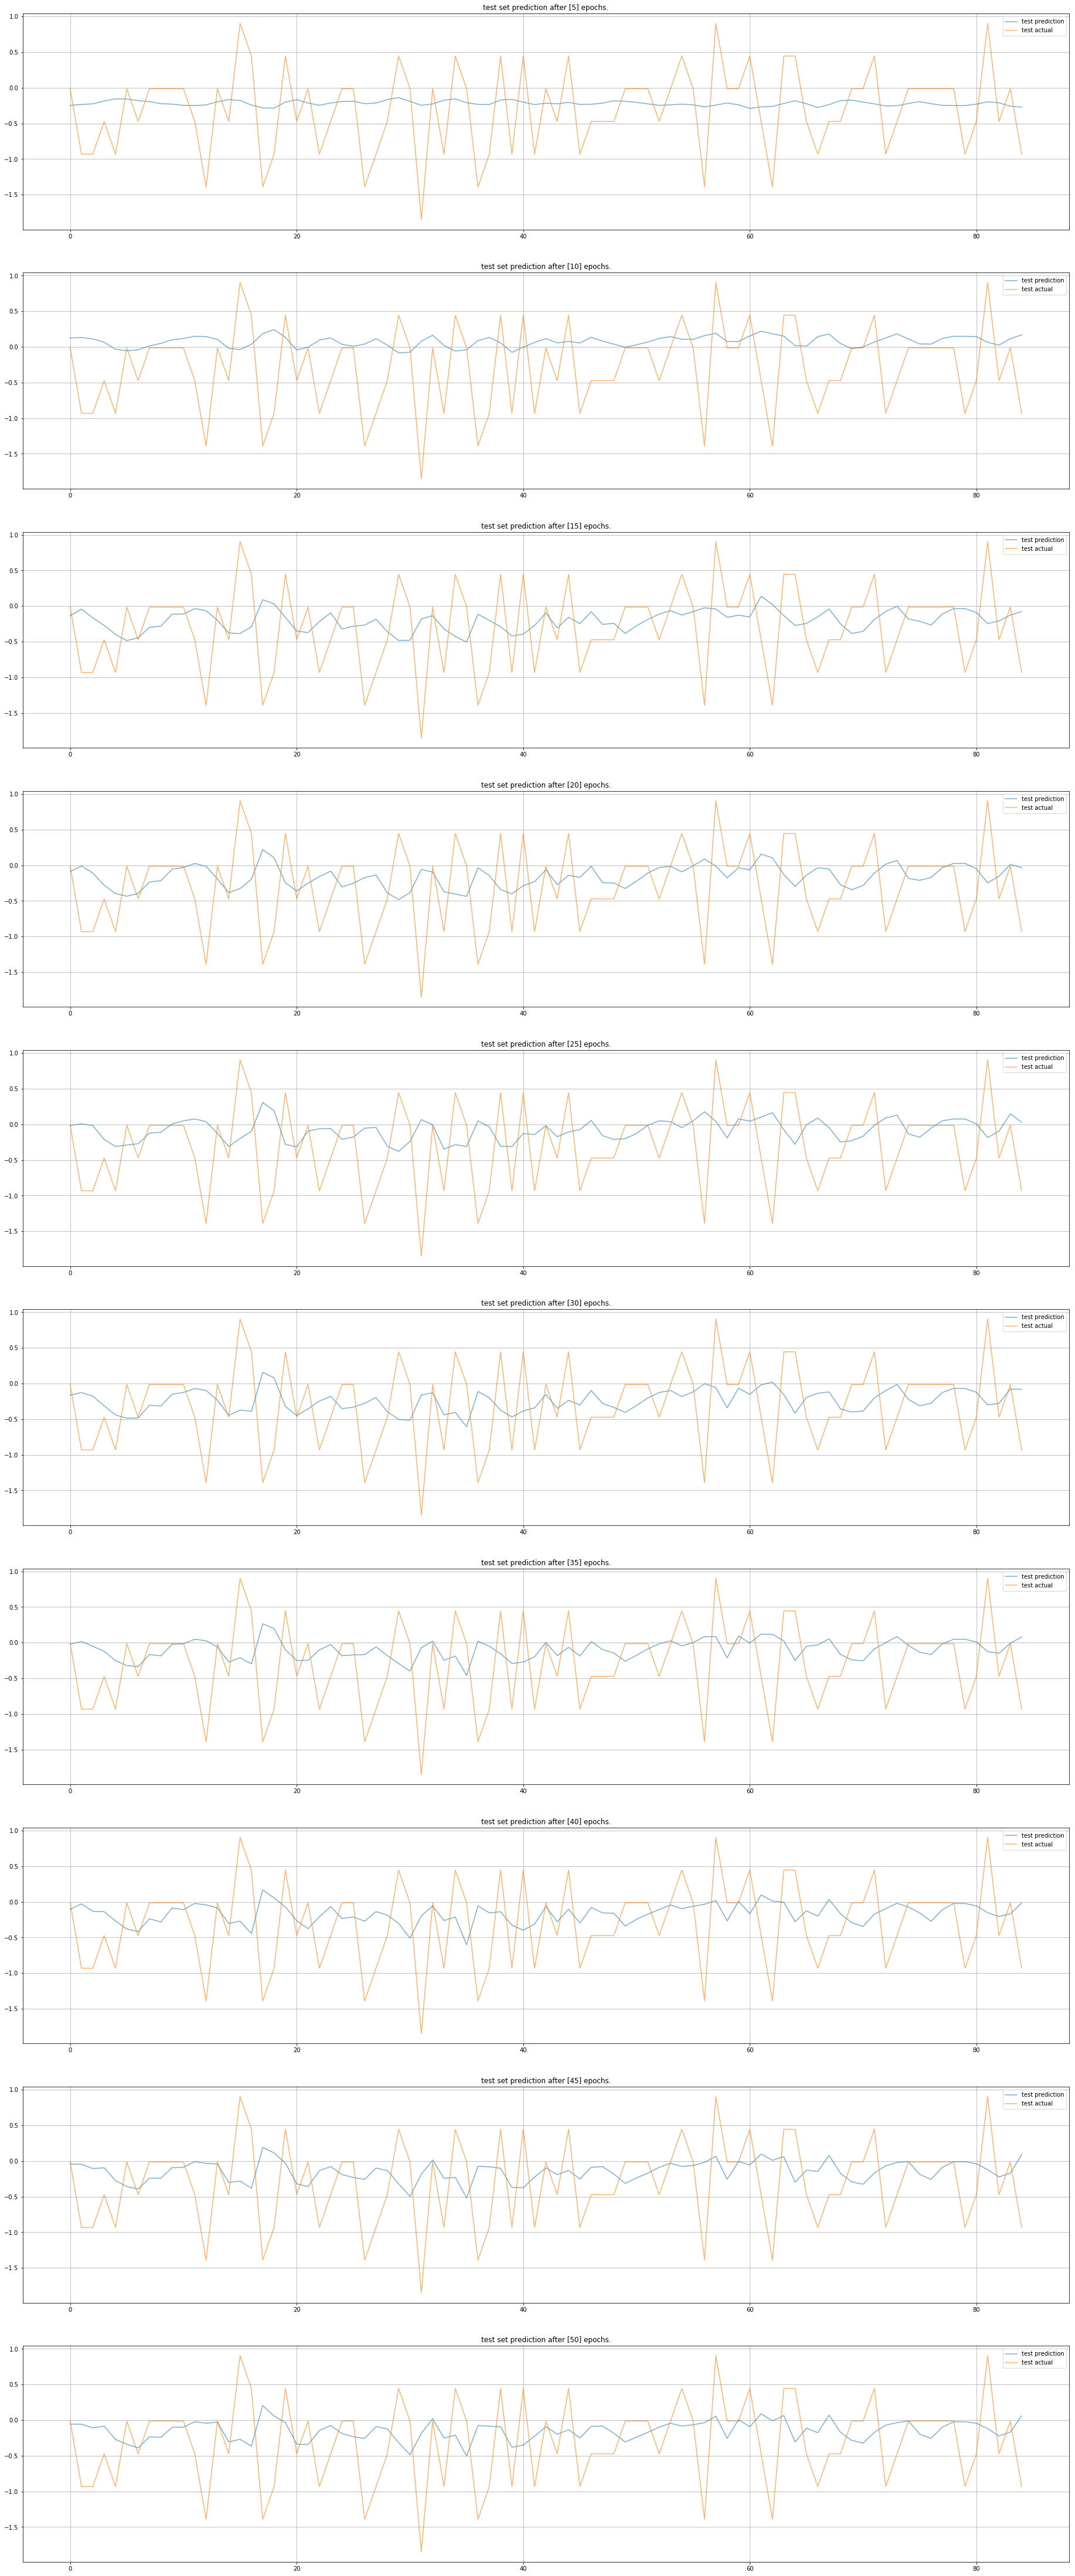

In [9]:
for (i, param) in enumerate(parameter_collection):
    print("================================================================")
    print(f"Executing hyper-parameter searching session [{i}/{len(parameter_collection) - 1}]...")
    print("Session Config:\n\t" + param["hparam_str"].replace("-", "\n\t"))
    start = datetime.now()
    hps_methods.individual_train(
        model_param=param,
        data_param=config.dp_config,
        exec_core=stacked_lstm.exec_core,
        file_dir=FILE_DIR
    )
    print(f"Time taken for session [{i}]: {str(datetime.now() - start)}.")